# S2AMP DEMO

The purpose of this notebook is to demostrate the use of mentorship data and trained model. 

- evaluation of the trained model
- SHAP of second_stage_features
- inference on a second stage feature file

In [4]:
import pandas as pd
import joblib
import numpy as np
from sklearn.metrics import classification_report
import os
from sklearn.metrics import confusion_matrix
from numpy import argmax
from sklearn.metrics import precision_recall_curve, roc_curve, auc, roc_auc_score
from numpy import arange
from sklearn.metrics import f1_score
import shap
from shap.plots import *
import seaborn as sns

## Evaluating the existing model on val data : Second Stage features

In [5]:
# get the data and model from aws s3 bucket
# https://docs.aws.amazon.com/cli/latest/userguide/getting-started-install.html - instructions to install aws cli
!aws s3 cp --no-sign-request s3://ai2-s2-research-public/s2amp/gold/lgb_second.stage.model.pkl data/gold/
!aws s3 cp --no-sign-request s3://ai2-s2-research-public/s2amp/gold/second_stage_features/val.csv data/gold/second_stage_features/
!aws s3 cp --no-sign-request s3://ai2-s2-research-public/s2amp/gold/second_stage_features/train.csv data/gold/second_stage_features/

download: s3://ai2-s2-research-public/s2amp/gold/lgb_second.stage.model.pkl to data/gold/lgb_second.stage.model.pkl
download: s3://ai2-s2-research-public/s2amp/gold/second_stage_features/val.csv to data/gold/second_stage_features/val.csv
download: s3://ai2-s2-research-public/s2amp/gold/second_stage_features/train.csv to data/gold/second_stage_features/train.csv


In [6]:
test_features_path = 'data/gold/second_stage_features/val.csv'
model_path = 'data/gold/lgb_second.stage.model.pkl'

df_features = pd.read_csv(os.path.join(test_features_path))
lgbm_pickle = joblib.load(os.path.join(model_path))
df_features

Trying to unpickle estimator LabelEncoder from version 0.24.2 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations


,mte_ai2id,coa_ai2id,is_mentor,copub_count,copub_end,copub_start,mentee_coauthors_before_copub,mentor_coauthors_before_copub,mentee_coauthors_after_copub,mentor_coauthors_after_copub,...,mte_out_sum,mte_in_sum,mte_weight_sum,coa_weight_sum,mte_ratio_in_out,coa_ratio_in_out,mte_avg_in,mte_avg_out,coa_avg_in,coa_avg_out
0,1678202,145535161,False,0.300000,2005,2003,171,384,474,528,...,0.0,0.015488,0.015488,0.015488,0.0,0.000000,0.015488,0.0,0.000000,0.015488
1,1678202,145375193,False,0.200000,2011,2010,777,633,825,774,...,0.0,0.004778,0.004778,1.125600,0.0,0.303149,0.002389,0.0,0.261846,0.431877
2,2152827668,145375193,True,0.285714,2010,2006,6,423,92,633,...,0.0,0.910538,0.910538,2.027147,0.0,0.148329,0.455269,0.0,0.261846,0.882651
3,1678202,1733877,False,0.089888,2007,1998,75,456,651,1332,...,0.0,1.271906,1.271906,1.471985,0.0,0.428170,0.254381,0.0,0.441306,0.257670
4,1754970,1733877,False,0.080000,2019,2008,567,1413,1724,2304,...,0.0,0.812587,0.812587,0.114595,0.0,0.000000,0.090287,0.0,0.000000,0.028649
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
368756,2155237413,153017162,False,0.111111,2018,2017,220,1773,234,2190,...,0.0,0.019497,0.019497,0.174723,0.0,1.074972,0.009749,0.0,0.022629,0.042102
368757,2155237413,3143251,False,0.157895,2019,2016,183,714,300,1027,...,0.0,0.034308,0.034308,0.057743,0.0,1.920409,0.008577,0.0,0.012657,0.009886
368758,2155237413,2104470,False,0.342105,2020,2016,183,669,359,1170,...,0.0,0.039576,0.039576,0.306719,0.0,57.217075,0.007915,0.0,0.100483,0.005269
368759,2155238014,144285580,False,0.105263,2011,2009,20,1884,25,2253,...,0.0,0.613447,0.613447,1.014820,0.0,0.000000,0.306724,0.0,0.000000,0.507410


getting the best threshold . . 
Threshold=0.300, F-Score=0.68027
              precision    recall  f1-score   support

       False       0.96      0.95      0.96    328489
        True       0.65      0.71      0.68     40272

    accuracy                           0.93    368761
   macro avg       0.81      0.83      0.82    368761
weighted avg       0.93      0.93      0.93    368761

AUROCC =  0.9508388376844448
AUPRC =  0.7337558659895229


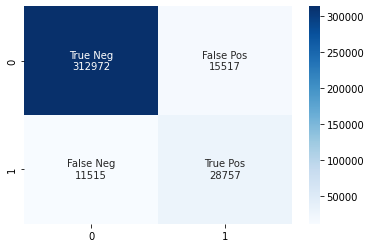

In [7]:
df_val = df_features.drop(
        [
            "mte_ai2id",
            "coa_ai2id",
            "is_mentor",
            "copub_end",
            "copub_start"
        ],
        axis=1,
    )
y_val = df_features['is_mentor']

yhat = lgbm_pickle.predict_proba(df_val)
# keep probabilities for the positive outcome only
probs = yhat[:, 1]

def to_labels(pos_probs, threshold):
	return (pos_probs >= threshold).astype('int')

# define thresholds
thresholds = arange(0, 1, 0.1)
# evaluate each threshold
print("getting the best threshold . . ")
scores = [f1_score(y_val, to_labels(probs, t)) for t in thresholds]

# get best threshold for highest F1
ix = argmax(scores)
print('Threshold=%.3f, F-Score=%.5f' % (thresholds[ix], scores[ix]))
print(classification_report(y_val, to_labels(probs, thresholds[ix])))
cf_matrix = confusion_matrix(y_val, to_labels(probs, thresholds[ix]))
group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ["{0:0.0f}".format(value) for value in
                cf_matrix.flatten()]
labels = [f"{v1}\n{v2}" for v1, v2 in
          zip(group_names,group_counts)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues')
print("AUROCC = ",roc_auc_score(y_val, probs))
# calculate AUPRC
precision, recall, _ = precision_recall_curve(y_val, probs)
print("AUPRC = ", auc(recall, precision))

## SHAP of Second Stage Classifier

In [8]:
df_train = pd.read_csv('data/gold/second_stage_features/train.csv')

X_train = df_train.drop(
        [
            "mte_ai2id",
            "coa_ai2id",
            "is_mentor",
            "copub_end",
            "copub_start"
        ],
        axis=1,
    )

y_train = df_train['is_mentor']

explainer = shap.Explainer(lgbm_pickle)
shap_values = explainer(X_train)

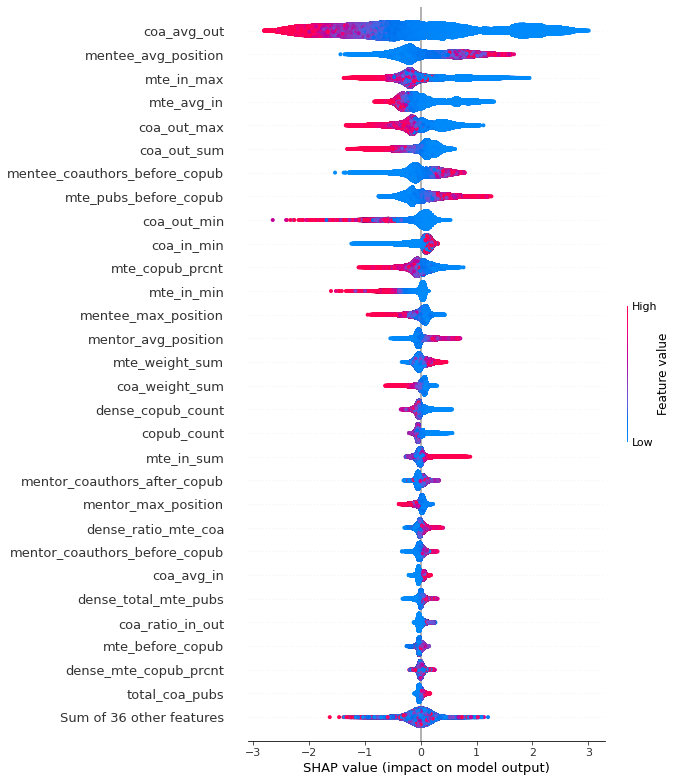

In [9]:
shap.plots.beeswarm(shap_values[:, :, 0], max_display=30)

# Using second stage classifier to predict on inferred data

In this section -
1. We load the second stage features
2. Using the classifier we predict the probability of mentorship
3. For a random example we demonstrate the effectiveness our model
4. Lastly, using `eli5` we explain why these predictions were made

In [10]:
# getting one second stage feature file
!aws s3 cp --no-sign-request s3://ai2-s2-research-public/s2amp/inferred/second_stage_features/features.1.csv data/inferred/second_stage_features/features.1.csv

download: s3://ai2-s2-research-public/s2amp/inferred/second_stage_features/features.1.csv to data/inferred/second_stage_features/features.1.csv


In [11]:
df_infer = pd.read_csv('data/inferred/second_stage_features/features.1.csv')
df_infer_buffer = df_infer.drop(
        [
            "mentee_ai2id",
            "mentor_ai2id",
            "copub_end",
            "copub_start"
        ],
        axis=1,
    )
probs = lgbm_pickle.predict_proba(df_infer_buffer)[:, 1]
pred_prob = pd.Series(probs, name='pred_prob')
df_pred_pair = pd.concat([df_infer,pred_prob],axis=1)
df_pred_pair = df_pred_pair[['mentee_ai2id', 'mentor_ai2id','pred_prob']]
df_pred_pair[df_pred_pair['pred_prob'] > 0.3] # using the threshold found above

,mentee_ai2id,mentor_ai2id,pred_prob
2,11724335,1387474555,0.343895
6,11950562,1387474555,0.655728
26,14002940,1387474555,0.373030
37,14849624,1387474555,0.358132
44,15371839,1387474555,0.349382
...,...,...,...
133781,1719082,1699402,0.552822
133786,1741164,1699402,0.751353
133793,1751838,1699402,0.809852
133797,1759505,1699402,0.679916


In [11]:
index = 133793 # explaining why this prediction was made for random example
print('Mentee S2  profile : https://www.semanticscholar.org/author/xyz/'+str(df_infer['mentee_ai2id'].loc[[index]].values[0]),
      '\nMentor S2 profile : https://www.semanticscholar.org/author/xyz/'+str(df_infer['mentor_ai2id'].loc[[index]].values[0]))

Mentee S2  profile : https://www.semanticscholar.org/author/xyz/1751838 
Mentor S2 profile : https://www.semanticscholar.org/author/xyz/1699402


- Mentee Name : Brandon Oselio
- Mentor Name : Alfred Hero
- Proof of mentorship - https://herogroup.engin.umich.edu/hero-group/
- Google scholar of mentee : https://scholar.google.com/citations?user=oeobOi0AAAAJ&hl=en&oi=sra
- Google scholar of mentor : https://scholar.google.com/citations?user=DSiNzkIAAAAJ&hl=en&oi=sra